# Real-time Control

#### Objective 🎯

In this notebook, we will develop a real-time control algorithm that maximizes the utilization of network's storage capacity. 

🤓 For you overachicers, if you complete this exercise, we have some more real-time control fun at **MAKE it google colab link** [Chapter_3_1_RTC_Advanced.ipynb](./Chapter_3_1_RTC_Advanced.ipynb)

In [2]:
# import the awesome numpy
import pystorms
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# RC parms for pretty plots 🎨
plt.rcParams.update({'font.size': 14})
plt.style.use('seaborn-v0_8-whitegrid')
plt.style.use('seaborn-v0_8-dark-palette')

### Presenting Scenario gamma from pystorms 🎉
In this example, we are using Scenario gamma. Scenario gamma is based on a real-world stormwater system. As described in more detail below, this network has 11 stormwater basins, each with a controllable valve at the basin outlet to hold/release water as desired.

The performance of control for this scenario is based on:
- Avoiding flooding at any of the basins, and
- Maintaining flow from each basin below a threshold of 0.11 cubic meters/second (around 4 cubic feet/second).
Ideally each basin will be nearly empty at the end of the simulation period so that they system has dewatered once the storm event is over.

Note: The units shown when plotting states (e.g., basin depth) will be imperial (e.g., ft, cubic feet/second).

![gamma](./data/gamma.png)

### Model IDs in Scenario gamma
```yaml
# name of scenario 
name: gamma
# state definitions
states:
        - !!python/tuple 
          - "1"
          - depthN
          # ... through "11" depthN
# Action space 
action_space:
        - O1
        # ... through O11
# Performance Targets
performance_targets:
        - !!python/tuple
          - O1
          - flow
          # ... through O11 flow
          - !!python/tuple
          - "1"
          - flooding
          # ... through "11" flooding
          - !!python/tuple 
          - "1"
          - depthN
          # ... through "11" depthN
```

As abbreviated above, the accessible states for this scenario are the depths in each stormwater basin, denoted 1, ..., 11.

The action space (i.e., what you can control) is made up of the settings for each basin outlet valve, denoted O1, ..., O11.

### Uncontrolled performance of Scenario gamma
In the uncontrolled case, all control assets are open (i.e., set to 1).

In [4]:
env = pystorms.scenarios.gamma()
done = False

while not done:
    # Query the current state of the simulation
    state = env.state()
    
    # Initialize actions to have each asset open
    actions = np.ones(11)
    
    # Set the actions and progress the simulation
    done = env.step(actions)
    
# Calculate the performance measure for the uncontrolled simulation
uncontrolled_perf = sum(env.data_log["performance_measure"])


 o  Retrieving project data

In [5]:
print("The calculated performance for the uncontrolled case of Scenario gamma is:")
print("{}.".format(uncontrolled_perf))

The calculated performance for the uncontrolled case of Scenario gamma is:
400221923.1344593.


We are going to focus on only controlling the furthest 4 downstream basin later. Let's look at the uncontrolled response for those 4 basins, including the fraction full for each basin (based on depth, aka filling degree) and the flow out of each basin.

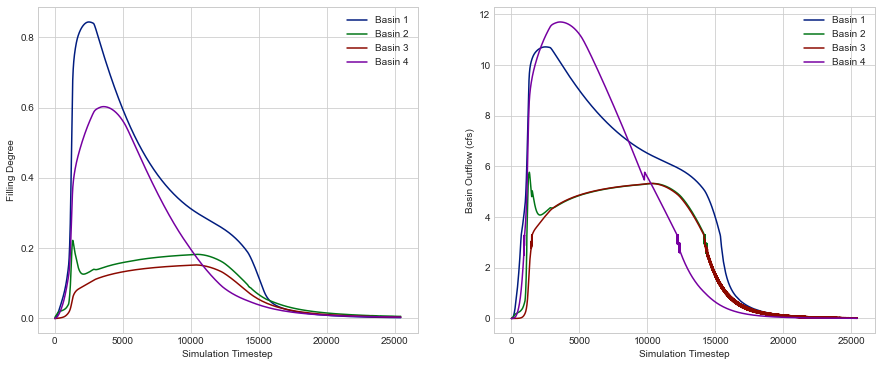

In [6]:
basin_max_depths = [5., 10., 10., 10.]

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(np.asarray(env.data_log['depthN']['1'])/basin_max_depths[0], label='Basin 1')
plt.plot(np.asarray(env.data_log['depthN']['2'])/basin_max_depths[1], label='Basin 2')
plt.plot(np.asarray(env.data_log['depthN']['3'])/basin_max_depths[2], label='Basin 3')
plt.plot(np.asarray(env.data_log['depthN']['4'])/basin_max_depths[3], label='Basin 4')
plt.xlabel('Simulation Timestep')
plt.ylabel('Filling Degree')
plt.legend()

plt.subplot(1,2,2)
plt.plot(env.data_log['flow']['O1'], label='Basin 1')
plt.plot(env.data_log['flow']['O2'], label='Basin 2')
plt.plot(env.data_log['flow']['O3'], label='Basin 3')
plt.plot(env.data_log['flow']['O4'], label='Basin 4')
plt.xlabel('Simulation Timestep')
plt.ylabel('Basin Outflow (cfs)')
plt.legend()

### Equal Filling Degree Control of Scenario gamma
##### A Summary of Equal Filling Degree
We will now set up an equal filling degree approach to control Scenario gamma. An equal filling degree approach aims to maintain each basin at the same relative fullness (aka filling degree). In this example, we will consider basin fullness based on depth (filling degree = current depth / basin maximum depth). However, depending on the objective of the control designer (i.e., you), equal filling degree can consider basin volume, pollutant load, etc. Many researchers have tailored and broadened the relatively simple equal filling degree approach for a number of use cases. For additional reading, we direct you to [Dirckx et al. (2014)](https://www.researchgate.net/publication/273137213_Real_Time_Control_From_Desk_Study_to_Full_Implementation), [Schutze et al. (2018)](https://doi.org/10.2166/wst.2018.172), and [Mullapudi et al. (2020)](https://doi.org/10.1016/j.advwatres.2020.103600) as starting places.

##### Getting Started ...
For this introductory example, instead of controlling the valves at the outlets of all 11 basins in the network, we will focus on controlling only the most downstream 4 basins, namely storage units 1, 2, 3, 4 with valves O1, O2, O3, O4.

We are first going to build the equal filling degree logic as a separate function we can call during each step of the simulation. This is just to keep our work a little more tidy. 🧹

The function below receives the current states that are most relevant and settings. In this case, the states are the depths of the 4 basins we are controlling, and the settings are for their respective outlet valves.

Tip💡: Parameter _c_ below regulates how reactively we open the valve with respect to the difference between a basin's filling degree and the average. For this example, we start with _c=1.5_.

Tip💡: Parameter _theta_ below can control the flashiness of the outflow hydrograph. For this example, we start with _theta=0.25_.

You can play around with these parameter values to see their respective impact on basin and system behavior. See [Mullapudi et al. (2020)](https://doi.org/10.1016/j.advwatres.2020.103600) for more information.

In [15]:
def controller_efd(state, max_depths):
    # Initialize the action space so that we can compute the new settings
    new_settings = np.ones(len(state))
    # Set equal filling degree parameters
    c = 1.5
    theta = 0.25
    
    # Assign the current depth in each basin
    depths = state
    
    # Compute the filling degrees
    fd = depths/max_depths
    # Compute the average filling degree across each controlled basin
    fd_average = sum(fd)/len(fd)
    
    # Update each valve setting based on the relative fullness of each basin
    for i in range(0,len(fd)):
        
        # If a basin is very full compared to the average, we should open its
        # valve to release some water
        if fd[i] > fd_average:
            new_settings[i] = c*(fd[i]-fd_average)
        
        # If a basin's filling degree is close to the average (within some value
        # theta), its setting can be close to that average
        elif fd_average-fd[i] <= theta:
            new_settings[i] = fd_average
            
        # If a basin is very empty compared to the average, we can close its
        # valve to store more water at that location, prioritizing releasing at
        # the other locations
        else:
            new_settings[i] = 0.
        
        # Make sure the settings are in bounds [0,1]
        new_settings[i] = min(new_settings[i], 1.)
        new_settings[i] = max(new_settings[i], 0.)

    return new_settings

Now we will use the above equal filling degree function to run the simulation and make the control decisions as prescribed.

In [16]:
env = pystorms.scenarios.gamma()
done = False

# Specify the maximum depths for each basin we are controlling
basin_max_depths = [5., 10., 10., 10.]

while not done:
    # Query the current state of the simulation
    state = env.state()
    # Isolate only the states that we need (the 4 downstream basin depths)
    states_relevant = state[0:4]
    
    # Pass the current, relevant states and the maximum basin 
    # depths into our equal filling degree logic
    actions_efd = controller_efd(states_relevant, basin_max_depths)
    # Specify that the other 7 valves in the network should be 
    # open since we are not controlling them here
    actions_uncontrolled = np.ones(7)
    # Join the two above action arrays
    actions = np.concatenate((actions_efd, actions_uncontrolled), axis=0)
    
    # Set the actions and progress the simulation
    done = env.step(actions)
    
# Calculate the performance measure for the uncontrolled simulation
equalfilling_perf = sum(env.data_log["performance_measure"])


 o  Retrieving project data

In [17]:
print("The calculated performance for the equal filling degree case of Scenario gamma is:")
print("{}.".format(equalfilling_perf))

The calculated performance for the equal filling degree case of Scenario gamma is:
402903110.84586245.


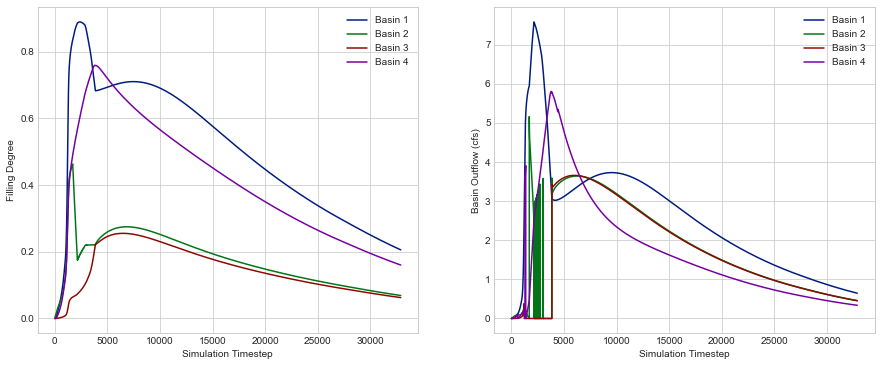

In [18]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(np.asarray(env.data_log['depthN']['1'])/basin_max_depths[0], label='Basin 1')
plt.plot(np.asarray(env.data_log['depthN']['2'])/basin_max_depths[1], label='Basin 2')
plt.plot(np.asarray(env.data_log['depthN']['3'])/basin_max_depths[2], label='Basin 3')
plt.plot(np.asarray(env.data_log['depthN']['4'])/basin_max_depths[3], label='Basin 4')
plt.xlabel('Simulation Timestep')
plt.ylabel('Filling Degree')
plt.legend()

plt.subplot(1,2,2)
plt.plot(env.data_log['flow']['O1'], label='Basin 1')
plt.plot(env.data_log['flow']['O2'], label='Basin 2')
plt.plot(env.data_log['flow']['O3'], label='Basin 3')
plt.plot(env.data_log['flow']['O4'], label='Basin 4')
plt.xlabel('Simulation Timestep')
plt.ylabel('Basin Outflow (cfs)')
plt.legend()

### Exercise 1

Toggle around with the equal filling degree parameters _c_ and _theta_ to see how they impact performance of our control and if you can improve the performance of this controller.

Question 🤔: Manually toggling this parameters can be tedious. What other approaches could we use to optimize these parameter selections?

### Exercise 2

Based on our initial control results (copied in the figure below), Basins 1 and 4 seem to be most utilized, while Basins 2 and 3 are rarely above a filling degree of 0.3. We can also see that Basin 2 outflow has some oscillations. This is likely due Basin 2's small size relative to the other basins.

![gamma efd results](./data/gamma_efd.png)

Note: The completely full volumes for each basin are approximately:

| Basin | Volume (1000 cf) |
| --- | ---: |
| 1 | 430 |
| 2 | 28 |
| 3 | 1,100 |
| 4 | 1,100 |
| 5 | 45 |
| 6 | 570 |
| 7 | 74 |
| 8 | 140 |
| 9 | 13 |
| 10 | 690 |
| 11 | 280 |

Looking again at the Scenario gamma network, should we consider controlling any other basins based on their location in the network? What other factors should we consider?

![gamma network](./data/gamma.png)